In [1]:
%reset -f
%matplotlib inline
import numpy as np
import lib.io.stan
import matplotlib.pyplot as plt
import os
from scipy import stats

In [2]:
data_dir = 'datasets/id001_ac'
results_dir = 'results/exp10/exp10.8/exp10.8.4'
fit_data_dir = f'{results_dir}/Rfiles'
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)

network = np.load(f'{data_dir}/AC_network.npz')
SC = network['SC']
K = np.max(SC)
SC = SC / K
SC[np.diag_indices(SC.shape[0])] = 0
gain_mat = network['gain_mat']

mdld_data = np.load(f'{data_dir}/AC_fit_trgt.npz')['fit_trgt']
mdld_data_ds = mdld_data[0:-1:20,:]

In [3]:
nn = SC.shape[0]
ns = gain_mat.shape[0]
nt = mdld_data_ds.shape[0]
I1 = 3.1

for sigma in np.array([0.001]):
    for epsilon in np.array([0.1]):
        data = {'nn':nn, 'ns':ns, 'nt':nt, 'I1':I1, 'SC':SC, 'gain': gain_mat,
                'sigma':sigma, 'epsilon':epsilon, 'slp':mdld_data_ds}
        input_Rfile = f'fit_data_sigma{sigma:0.5f}_eps{epsilon:0.5f}.R'
        os.makedirs(fit_data_dir,exist_ok=True)
        lib.io.stan.rdump(f'{fit_data_dir}/{input_Rfile}',data)

In [4]:
%%bash
stancompile.sh vep-snsrfit-cntr

/home/anirudh/Academia/projects/vep.stan
make: '/home/anirudh/Academia/projects/vep.stan/vep-snsrfit-cntr' is up to date.


In [5]:
%%bash -s "$results_dir" "$input_Rfile" "$sigma" "$epsilon"
#srun -p rhu -t 24:00:00
RESULTS_DIR=$1
INPUT_RFILE=$2
SIGMA=$(printf "%.5f" ${3})
EPSILON=$(printf "%.5f" ${4})
for i in {1..4};
do
./vep-snsrfit-cntr variational iter=1000000 tol_rel_obj=0.01 \
output_samples=1000 data file=${RESULTS_DIR}/Rfiles/${INPUT_RFILE} \
output file=${RESULTS_DIR}/samples_sigma${SIGMA}_eps${EPSILON}_chain${i}.csv \
&> ${RESULTS_DIR}/logs/snsrfit_cntr_sigma${SIGMA}_epsilon${EPSILON}_chain${i}.log &
done
wait

In [6]:
# import lib.io.stan
# import importlib
# importlib.reload(lib.io.stan)

# csv_fname = f'{results_dir}/samples_sigma0.10000_eps0.10000.csv'
# nwarmup = 200
# nsampling = 200
# variables_of_interest = ['lp__','accept_stat__','stepsize__','treedepth__','n_leapfrog__',\
#                          'divergent__', 'energy__','x0',  'x', 'z', 'amplitude', 'offset',\
#                          'x_init', 'z_init', 'time_step']
fname_suffix = 'sigma0.00100_eps0.10000'
pstr_samples_1 = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}_chain{i}.csv' for i in range(1,5)]) # read sampler diagnostics and x0 for all sampling iterations
# csv_fname = 'results/exp10/exp10.4/samples_eps0.1_chain1.csv'
# nwarmup = 1000
# nsampling = 1000
# ignore_warmup = True
# variables_of_interest = ['x','z']
# pstr_samples_2 = lib.io.stan.read_samples(csv_fname,nwarmup,nsampling,ignore_warmup,variables_of_interest) # read 10 samples of hidden state variables x and z

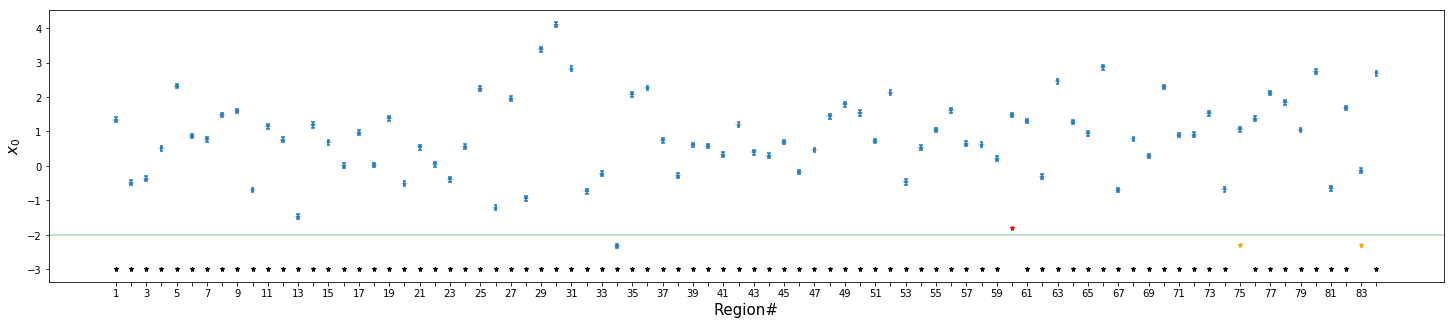

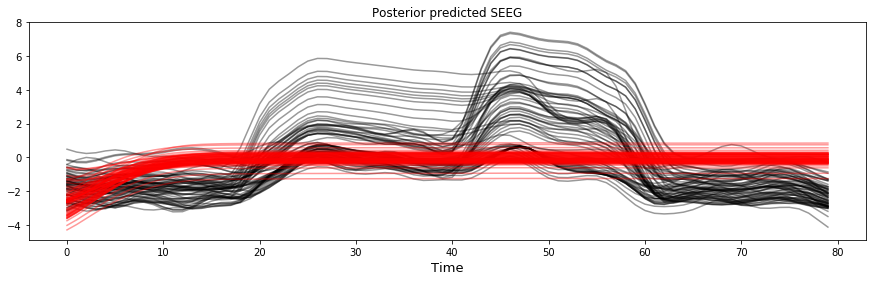

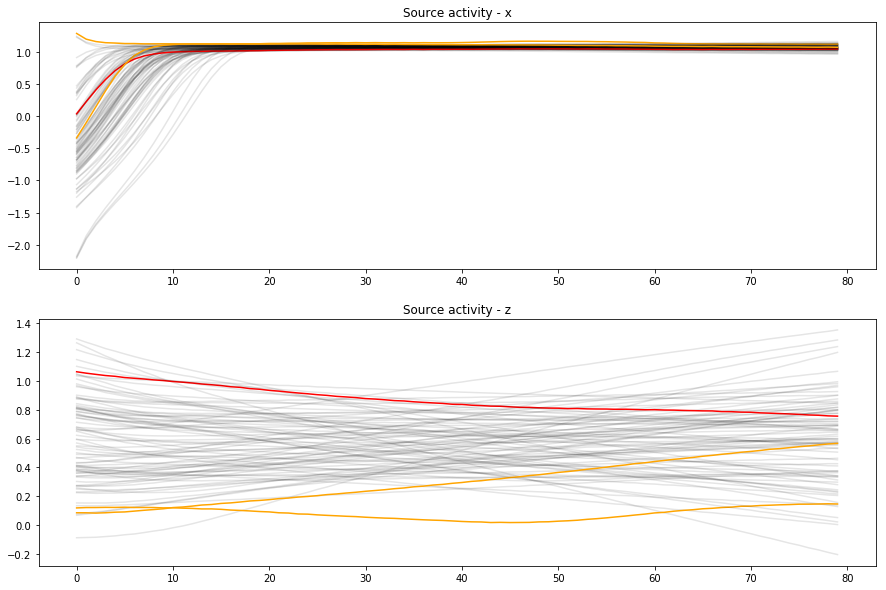

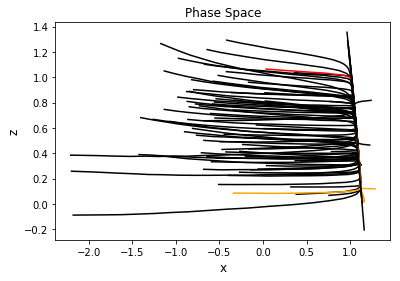

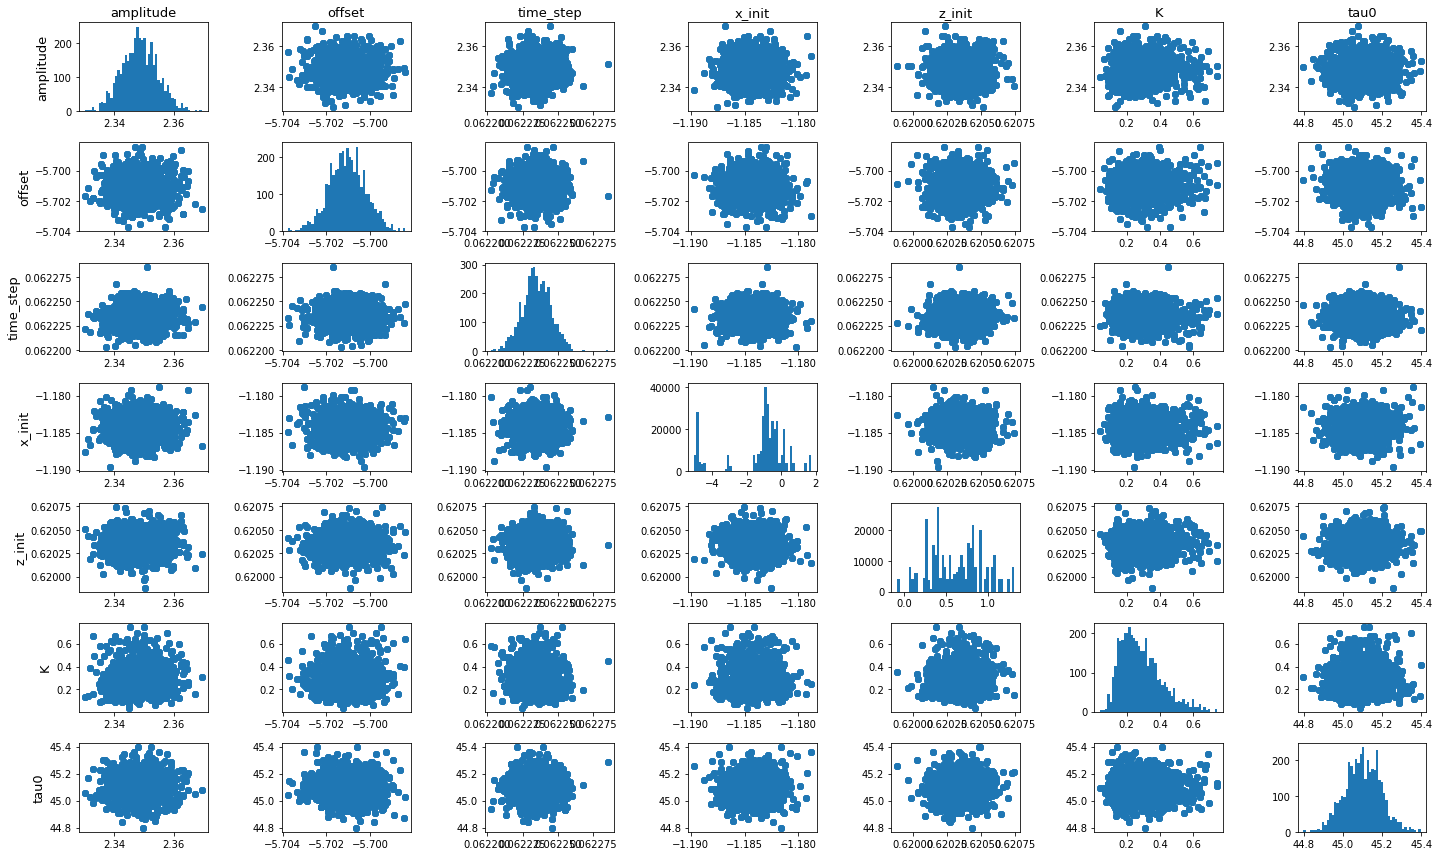

In [7]:
# import importlib
# importlib.reload(lib.io.stan)

syn_data = np.load('datasets/id001_ac/AC_syn_tvb_ez=59_pz=82-74.npz')
x0_true = syn_data['x0']
ez = syn_data['ez']
pz= np.concatenate((syn_data['pz_x0'], syn_data['pz_kplng']))

lib.plots.stan.x0_violin(pstr_samples_1['x0'], x0_true, ez, pz, figsize=(25,5), figname=f'{results_dir}/figures/x0_violin_{fname_suffix}.png')

ntwrk = np.load('datasets/id001_ac/AC_network.npz')
gain = ntwrk['gain_mat']
src_sig = pstr_samples_1['x']
amplitude = pstr_samples_1['amplitude']
offset = pstr_samples_1['offset']
slp = np.zeros([src_sig.shape[0],src_sig.shape[1],gain.shape[0]])
for i,sample in enumerate(src_sig):
#     seeg[i] = amplitude[i,:] * ((gain @ sample.T).T + offset[i,:]);
    slp[i] = amplitude[i] * (np.log(gain @ np.exp(sample).T).T + offset[i])

slp_mean = np.mean(slp, axis=0)

mdld_data = np.load('datasets/id001_ac/AC_fit_trgt.npz')
plt.figure(figsize=(15,4))
plt.plot(mdld_data_ds,'k',alpha=0.4);
plt.plot(slp_mean, 'r', alpha=0.4);
plt.title('Posterior predicted SEEG')
plt.xlabel('Time', fontsize=13)
plt.savefig(f'{results_dir}/figures/ppc_{fname_suffix}.png')


x_mean = np.mean(pstr_samples_1['x'], axis=0)
z_mean = np.mean(pstr_samples_1['z'], axis=0)

plt.figure(figsize=(15, 10))
ax_src_x = plt.subplot(211)
ax_src_z = plt.subplot(212)
sample_idx = -1
for i in range(84):
    if i in ez: 
        ax_src_x.plot(x_mean[:, i], color='red');
        ax_src_z.plot(z_mean[:, i], color='red');
    elif i in pz:
        ax_src_x.plot(x_mean[:, i], color='orange');
        ax_src_z.plot(z_mean[:, i], color='orange');
    else:
        ax_src_x.plot(x_mean[:, i], color='black', alpha=0.1);
        ax_src_z.plot(z_mean[:, i], color='black', alpha=0.1);
ax_src_x.set_title("Source activity - x")
ax_src_z.set_title("Source activity - z")
plt.savefig(f'{results_dir}/figures/src_inferred_{fname_suffix}.png')

plt.figure()
for i in range(84):
    if i in ez: 
        plt.plot(x_mean[:, i], z_mean[:, i], color='red')
    elif i in pz:
        plt.plot(x_mean[:, i], z_mean[:, i], color='orange')
    else:
        plt.plot(x_mean[:, i], z_mean[:, i], color='black')
plt.xlabel('x', fontsize=12.0)
plt.ylabel('z', fontsize=12.0)
plt.title('Phase Space')
plt.savefig(f'{results_dir}/figures/phase_space_{fname_suffix}.png')


plt.figure(figsize=(20,12))
params = ['amplitude', 'offset', 'time_step', 'x_init', 'z_init', 'K', 'tau0']
nParams = len(params)
for i in range(nParams):
    for j in range(nParams):
        plt.subplot(nParams, nParams, i * nParams + (j + 1))
        if(i == j):
            plt.hist(pstr_samples_1[params[i]].flatten(), bins=50)
        else:
            xvals = np.mean(pstr_samples_1[params[j]], axis=1) if len(pstr_samples_1[params[j]].shape)>1 else pstr_samples_1[params[j]]
            yvals = np.mean(pstr_samples_1[params[i]], axis=1) if len(pstr_samples_1[params[i]].shape)>1 else pstr_samples_1[params[i]]
            plt.plot(xvals, yvals, 'o')
        if(i == 0):
            plt.title(params[j], fontsize=13)
        if(j == 0):
            plt.ylabel(params[i], fontsize=13)
plt.tight_layout()
plt.savefig(f'{results_dir}/figures/params_pair_plots_{fname_suffix}.png')


Simulation of 2D epileptor at posterior mean of $x_0, \tau_0, K$

In [8]:
# data_dir = 'datasets/id001_ac'
# results_dir = 'tmp'
# fit_data_dir = f'{results_dir}/Rfiles' #'jureca/data'

# network = np.load(f'{data_dir}/AC_network.npz')
# SC = network['SC']
# K = np.max(SC)
# SC = SC / K
# K = 0.001069
# SC[np.diag_indices(SC.shape[0])] = 0
# gain = network['gain_mat']
# syn_data = np.load(f'{data_dir}/AC_syn_tvb_ez=59_pz=82-74.npz')

# nn = SC.shape[0]
# ns = gain.shape[0]
# nt = 1600
# I1 = 3.1
tau0_mean = np.mean(pstr_samples_1['tau0'])
x0_mean = np.mean(pstr_samples_1['x0'], axis=0)
x_init_mean = np.mean(pstr_samples_1['x_init'], axis=0)
z_init_mean = np.mean(pstr_samples_1['z_init'], axis=0)
time_step_mean = np.mean(pstr_samples_1['time_step'])
amplitude_mean = np.mean(pstr_samples_1['amplitude'])
offset_mean = np.mean(pstr_samples_1['offset'])
K_mean = np.mean(pstr_samples_1['K'])
print(x0_mean, x_init_mean, z_init_mean, time_step_mean, tau0_mean, amplitude_mean, offset_mean, K_mean)

[ 1.33279899 -0.49021073 -0.37504744  0.51030005  2.31071677  0.86873578
  0.77203735  1.48246189  1.60003681 -0.69575047  1.15136409  0.75457207
 -1.46750969  1.20228632  0.69286613  0.01236715  0.96223739  0.02632123
  1.39051856 -0.51131107  0.56281441  0.04514395 -0.38956372  0.56115304
  2.2395649  -1.21570235  1.95357363 -0.93950307  3.39101641  4.09645292
  2.81691576 -0.72638315 -0.22262695 -2.3226025   2.07474053  2.26487491
  0.74132111 -0.27676392  0.60795483  0.57476094  0.3252977   1.20113381
  0.40747812  0.29590482  0.69107514 -0.1743831   0.46762009  1.44004126
  1.79605576  1.53543189  0.71261434  2.12181076 -0.45393493  0.53488166
  1.04563443  1.61269071  0.6418765   0.61875068  0.20890386  1.4757035
  1.3010968  -0.30760412  2.45863374  1.27342418  0.9557736   2.86869878
 -0.69896066  0.79069063  0.283541    2.29791208  0.89627738  0.91190817
  1.52304217 -0.67389374  1.06879285  1.37073649  2.11815343  1.84407986
  1.04493769  2.7383454  -0.64861109  1.69315814 -0.

In [9]:
data = {'nn':nn, 'ns':ns, 'nt':nt, 'I1':I1, 'tau0':tau0_mean, 'gain':gain, 'SC':SC, \
        'K':K_mean, 'x0':x0_mean, 'x_init':x_init_mean, 'z_init':z_init_mean, \
        'time_step':time_step_mean, 'amplitude': amplitude_mean, 'offset':offset_mean}
lib.io.stan.rdump(f'{results_dir}/Rfiles/posterior_simulation_data_{fname_suffix}.R', data)

In [10]:
%%bash
stancompile.sh vep-forwardsim-2Depileptor-ode-nointerp

/home/anirudh/Academia/projects/vep.stan
make: '/home/anirudh/Academia/projects/vep.stan/vep-forwardsim-2Depileptor-ode-nointerp' is up to date.


In [11]:
%%bash -s "$results_dir" "$fname_suffix"
./vep-forwardsim-2Depileptor-ode-nointerp sample num_warmup=0 num_samples=1 algorithm=fixed_param \
data file=$1/Rfiles/posterior_simulation_data_${2}.R output file=$1/posterior_simulation_${2}.csv

method = sample (Default)
  sample
    num_samples = 1
    num_warmup = 0
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      delta = 0.80000000000000004 (Default)
      kappa = 0.75 (Default)
      t0 = 10 (Default)
      init_buffer = 75 (Default)
      term_buffer = 50 (Default)
      window = 25 (Default)
    algorithm = fixed_param
id = 0 (Default)
data
  file = results/exp10/exp10.8/exp10.8.4/Rfiles/posterior_simulation_data_sigma0.00100_eps0.10000.R
init = 2 (Default)
random
  seed = 3035946863
output
  file = results/exp10/exp10.8/exp10.8.4/posterior_simulation_sigma0.00100_eps0.10000.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)

Iteration: 1 / 1 [100%]  (Sampling)

 Elapsed Time: 0 seconds (Warm-up)
               0.012494 seconds (Sampling)
               0.012494 seconds (Total)



In [12]:
sim_data = lib.io.stan.read_samples([f'{results_dir}/posterior_simulation_{fname_suffix}.csv'])
fit_data = np.load(f'{data_dir}/AC_fit_trgt.npz')
x_syn = syn_data['src_sig'][2200:3800,0,:,0] + syn_data['src_sig'][2200:3800,3,:,0]
ez = syn_data['ez']
pz = np.concatenate((syn_data['pz_x0'], syn_data['pz_kplng']))

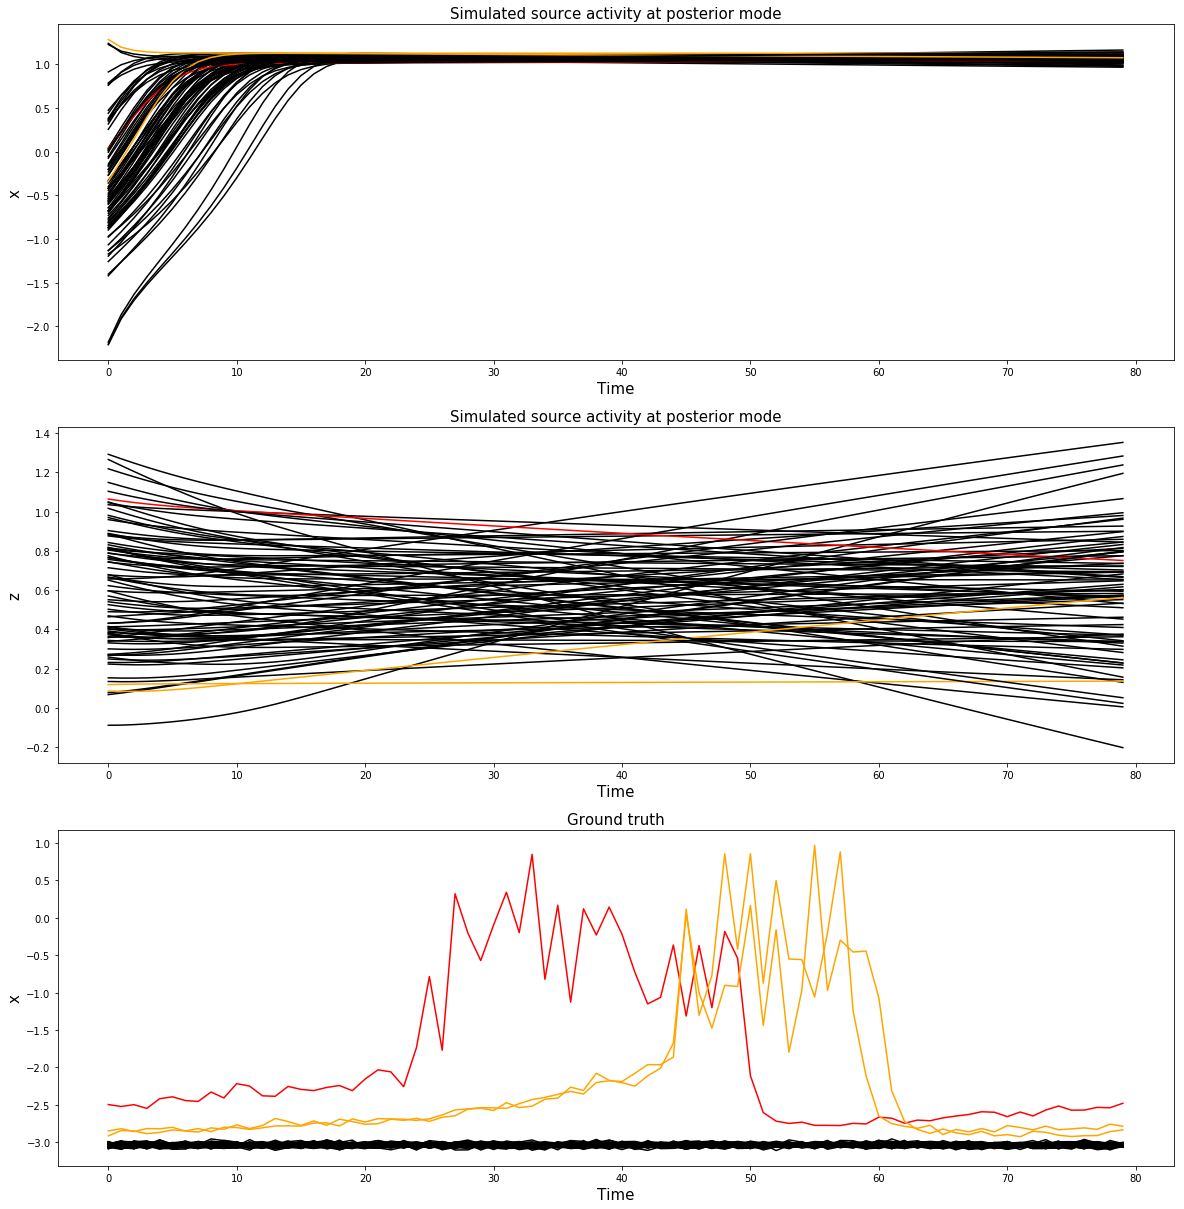

In [13]:
x_sim = sim_data['x'][0,:,:]
z_sim = sim_data['z'][0,:,:]
plt.figure(figsize=(20,21))
plt.subplot(311)
for i in range(nn):
    if(i in ez):
        plt.plot(x_sim[:,i], color='red');
    elif(i in pz):
        plt.plot(x_sim[:,i], color='orange');
    else:
        plt.plot(x_sim[:,i], color='black');
plt.xlabel('Time', fontsize=15)
plt.ylabel('x', fontsize=15)
plt.title('Simulated source activity at posterior mode', fontsize=15)

plt.subplot(312)
for i in range(nn):
    if(i in ez):
        plt.plot(z_sim[:,i], color='red');
    elif(i in pz):
        plt.plot(z_sim[:,i], color='orange');
    else:
        plt.plot(z_sim[:,i], color='black');
plt.xlabel('Time', fontsize=15)
plt.ylabel('z', fontsize=15)
plt.title('Simulated source activity at posterior mode', fontsize=15)


plt.subplot(313)
for i in range(nn):
    if(i in ez):
        plt.plot(x_syn[0:-1:20,i], color='red');
    elif(i in pz):
        plt.plot(x_syn[0:-1:20,i], color='orange');
    else:
        plt.plot(x_syn[0:-1:20,i], color='black');
plt.title('Ground truth', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.ylabel('x', fontsize=15)
plt.savefig(f'{results_dir}/figures/posterior_simulation_src_{fname_suffix}.png')


# plt.plot(z + 4*np.r_[0:84]);
# plt.yticks(4*np.r_[0:84],np.r_[0:84]);

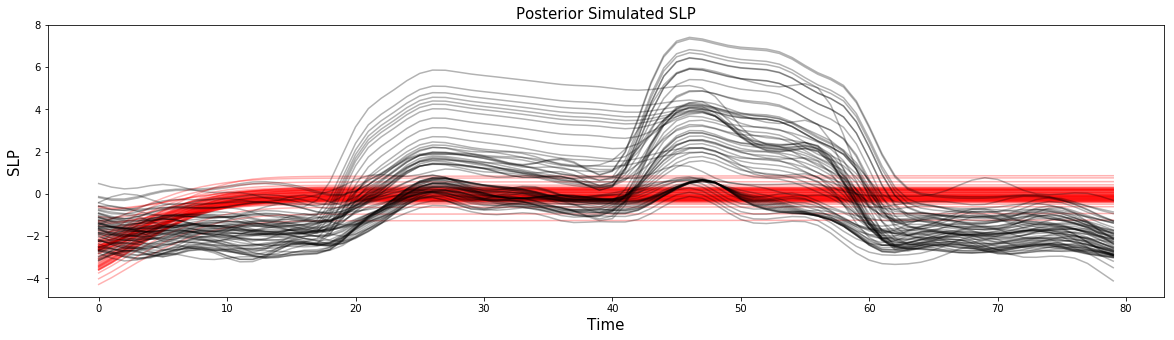

In [14]:
amp = 4.0
offset = -3
slp = sim_data['slp'][0]
plt.figure(figsize=(20,5))
plt.plot(slp, color='red', alpha=0.3);

plt.plot(fit_data['fit_trgt'][0:-1:20,:], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=15)
plt.ylabel('SLP', fontsize=15)
plt.title('Posterior Simulated SLP', fontsize=15)
plt.savefig(f'{results_dir}/figures/posterior_simulated_slp_{fname_suffix}.png')

Compare source activity of simulation with all parameters set to mean of inferred values except for $x_0$ (it is set to ground truth)

In [15]:
data = {'nn':nn, 'ns':ns, 'nt':nt, 'I1':I1, 'tau0':tau0_mean, 'gain':gain, 'SC':SC, \
        'K':K_mean, 'x0':x0_true, 'x_init':x_init_mean, 'z_init':z_init_mean, \
        'time_step':time_step_mean, 'amplitude': amplitude_mean, 'offset':offset_mean}
lib.io.stan.rdump(f'{results_dir}/Rfiles/posterior_simulation_x0_true_otherparams_meaninferred.R', data)

In [16]:
%%bash
stancompile.sh vep-forwardsim-2Depileptor-ode-nointerp

/home/anirudh/Academia/projects/vep.stan
make: '/home/anirudh/Academia/projects/vep.stan/vep-forwardsim-2Depileptor-ode-nointerp' is up to date.


In [17]:
%%bash -s "$results_dir" "$fname_suffix"
./vep-forwardsim-2Depileptor-ode-nointerp sample num_warmup=0 num_samples=1 algorithm=fixed_param \
data file=$1/Rfiles/posterior_simulation_x0_true_otherparams_meaninferred.R output file=$1/posterior_simulation_x0_true_otherparams_meaninferred_${2}.csv

method = sample (Default)
  sample
    num_samples = 1
    num_warmup = 0
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      delta = 0.80000000000000004 (Default)
      kappa = 0.75 (Default)
      t0 = 10 (Default)
      init_buffer = 75 (Default)
      term_buffer = 50 (Default)
      window = 25 (Default)
    algorithm = fixed_param
id = 0 (Default)
data
  file = results/exp10/exp10.8/exp10.8.4/Rfiles/posterior_simulation_x0_true_otherparams_meaninferred.R
init = 2 (Default)
random
  seed = 3036002455
output
  file = results/exp10/exp10.8/exp10.8.4/posterior_simulation_x0_true_otherparams_meaninferred_sigma0.00100_eps0.10000.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)

Iteration: 1 / 1 [100%]  (Sampling)

 Elapsed Time: 0 seconds (Warm-up)
               0.012628 seconds (Sampling)
               0.012628 seconds (Total)



In [18]:
sim_data = lib.io.stan.read_samples([f'{results_dir}/posterior_simulation_x0_true_otherparams_meaninferred_{fname_suffix}.csv'])
fit_data = np.load(f'{data_dir}/AC_fit_trgt.npz')
x_syn = syn_data['src_sig'][2200:3800,0,:,0] + syn_data['src_sig'][2200:3800,3,:,0]
ez = syn_data['ez']
pz = np.concatenate((syn_data['pz_x0'], syn_data['pz_kplng']))

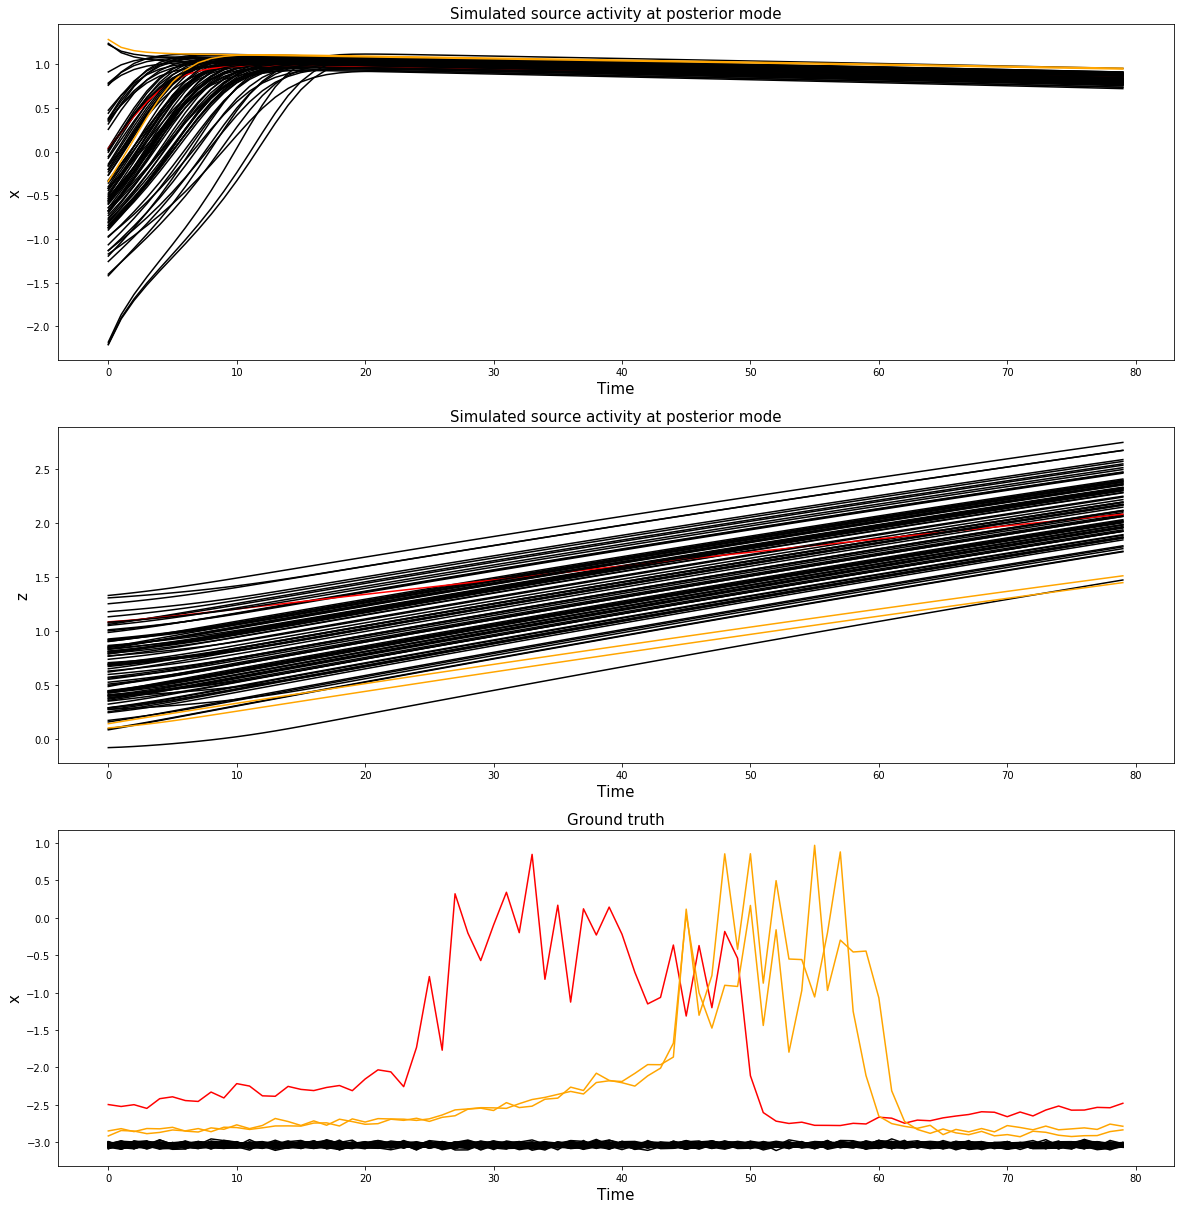

In [19]:
x_sim = sim_data['x'][0,:,:]
z_sim = sim_data['z'][0,:,:]
plt.figure(figsize=(20,21))
plt.subplot(311)
for i in range(nn):
    if(i in ez):
        plt.plot(x_sim[:,i], color='red');
    elif(i in pz):
        plt.plot(x_sim[:,i], color='orange');
    else:
        plt.plot(x_sim[:,i], color='black');
plt.xlabel('Time', fontsize=15)
plt.ylabel('x', fontsize=15)
plt.title('Simulated source activity at posterior mode', fontsize=15)

plt.subplot(312)
for i in range(nn):
    if(i in ez):
        plt.plot(z_sim[:,i], color='red');
    elif(i in pz):
        plt.plot(z_sim[:,i], color='orange');
    else:
        plt.plot(z_sim[:,i], color='black');
plt.xlabel('Time', fontsize=15)
plt.ylabel('z', fontsize=15)
plt.title('Simulated source activity at posterior mode', fontsize=15)


plt.subplot(313)
for i in range(nn):
    if(i in ez):
        plt.plot(x_syn[0:-1:20,i], color='red');
    elif(i in pz):
        plt.plot(x_syn[0:-1:20,i], color='orange');
    else:
        plt.plot(x_syn[0:-1:20,i], color='black');
plt.title('Ground truth', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.ylabel('x', fontsize=15)
plt.savefig(f'{results_dir}/figures/posterior_simulation_x0_true_otherparams_inferred_src_{fname_suffix}.png')


# plt.plot(z + 4*np.r_[0:84]);
# plt.yticks(4*np.r_[0:84],np.r_[0:84]);

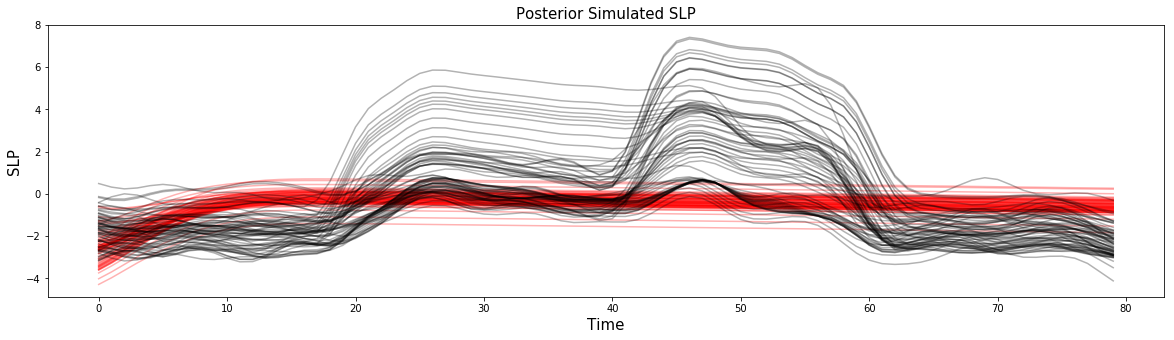

In [20]:
amp = 4.0
offset = -3
slp = sim_data['slp'][0]
plt.figure(figsize=(20,5))
plt.plot(slp, color='red', alpha=0.3);

plt.plot(fit_data['fit_trgt'][0:-1:20,:], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=15)
plt.ylabel('SLP', fontsize=15)
plt.title('Posterior Simulated SLP', fontsize=15)
plt.savefig(f'{results_dir}/figures/posterior_simulated_slp_x0_true_otherparams_meaninferred_{fname_suffix}.png')